In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv(r"C:\Users\jjap2\Poleto SCE\Poleto-SCE\dond_game_data.csv")

In [10]:
#cleaning cell
df["Remaining Values"] = df["Remaining Values"].apply(ast.literal_eval)

all_values = set()
for values in df["Remaining Values"]:
    all_values.update(values)

for value in sorted(all_values):
    df[f"Case_{value}"] = df["Remaining Values"].apply(lambda x: 1 if value in x else 0)

df.drop(columns=["Remaining Values"], inplace=True)
df.drop(columns=["Contestant Name"], inplace=True)

categorical_columns = ["Contestant Gender", "Contestant Race"]
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [11]:
# defining variables
X = df.drop(columns=["Offer"])
y = df["Offer"]

In [12]:
# standardize!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

lasso = LassoCV(cv=5, random_state=42).fit(X_train, y_train)

In [14]:
Alpha = lasso.alpha_
lasso_coefs = lasso.coef_

print("Alpha:", Alpha
      )
print("LASSO Coefficients:", lasso_coefs)

Alpha: 102.35749552417937
LASSO Coefficients: [-1.64682964e+01  9.25925245e+03 -2.81935066e+04  1.24093999e+05
 -4.61560432e+02  3.43371398e+03  3.20291622e+04  1.95378778e+03
 -1.29902898e+03  6.18709701e+03 -4.37207744e+03  2.31555314e+03
  3.32703615e+03  7.59231924e+02  1.89922120e+03  3.74992759e+03
 -0.00000000e+00  3.62721545e+03  3.15759662e+03  2.91698604e+03
  2.11013909e+03  3.27692660e+03  2.88449604e+03  2.09962166e+03
  4.57737307e+03  9.43586219e+02  0.00000000e+00  2.86615936e+03
 -1.19780428e+03 -0.00000000e+00  5.25969740e+03  2.29499587e+03
 -0.00000000e+00  2.39394348e+03  1.41931183e+03  9.76661258e+01
  4.49003848e+03  1.26837042e+03  2.45955141e+03 -7.15417391e+03
  1.66426285e+03  0.00000000e+00  1.22700554e+03 -1.70915424e+03
 -5.44142464e+03 -7.18134007e+02 -6.42080027e+03 -4.68761375e+02
 -3.20557561e+03 -0.00000000e+00 -9.54883889e+03 -2.62084743e+02
  5.39106716e+02  0.00000000e+00 -2.80022205e+03  2.09476360e+02]


In [15]:
nz_feats = X.columns[lasso.coef_ != 0]
nz_coefs = lasso.coef_[lasso.coef_ != 0]
nz_feat_list = list(zip(nz_feats, nz_coefs))
nz_feat_list.sort(key=lambda x: abs(x[1]), reverse=True)

print("Important Features and Their LASSO Coefficients:")
for feature, coef in nz_feat_list:
    print(f"{feature}: {coef:.4f}")


Important Features and Their LASSO Coefficients:
Board Average: 124093.9991
Offer Percent of Average: 32029.1622
Board Value: -28193.5066
Case_6000000: -9548.8389
Round: 9259.2524
Case_250000: -7154.1739
Case_1000000: -6420.8003
Postgame: 6187.0970
Case_750000: -5441.4246
Case_5000: 5259.6974
Case_500: 4577.3731
Case_100000: 4490.0385
Probability of Big Value: -4372.0774
Case_10: 3749.9276
Case_25: 3627.2155
Previous Offer: 3433.7140
Case_1: 3327.0361
Case_200: 3276.9266
Case_2000000: -3205.5756
Case_50: 3157.5966
Case_75: 2916.9860
Case_300: 2884.4960
Case_1000: 2866.1594
Contestant Race_Hispanic: -2800.2221
Case_200000: 2459.5514
Case_25000: 2393.9435
Case_0: 2315.5531
Case_10000: 2294.9959
Case_100: 2110.1391
Case_400: 2099.6217
Deal: 1953.7878
Case_5: 1899.2212
Case_600000: -1709.1542
Case_300000: 1664.2628
Case_50000: 1419.3118
Amount Won: -1299.0290
Case_150000: 1268.3704
Case_500000: 1227.0055
Case_1500: -1197.8043
Case_750: 943.5862
Case_2: 759.2319
Case_800000: -718.1340
Conte

In [16]:
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse:.2f}, Test MSE: {test_mse:.2f}")
print(f"Train R²: {train_r2:.2f}, Test R²: {test_r2:.2f}")

Train MSE: 438349887.87, Test MSE: 437787531.79
Train R²: 0.97, Test R²: 0.97


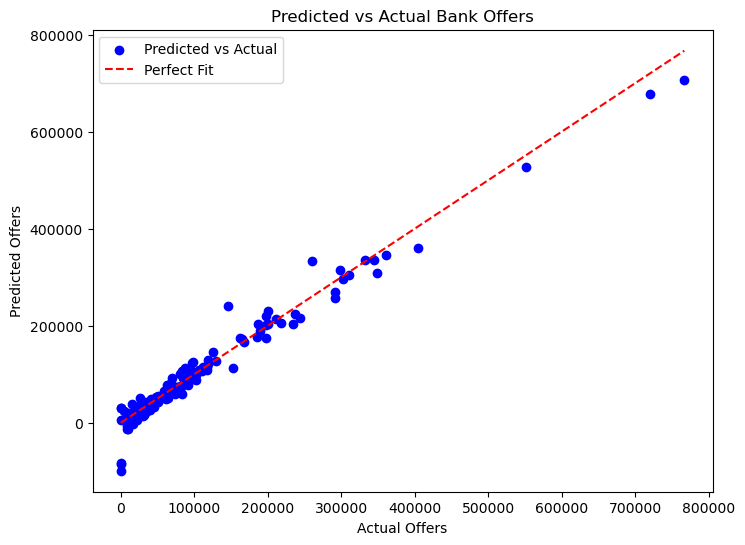

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Offers")
plt.ylabel("Predicted Offers")
plt.title("Predicted vs Actual Bank Offers")
plt.legend()
plt.show()

In [ ]:
results = df.loc[y_test.index, ["Game ID", "Round"]].copy()
results["Actual Offer"] = y_test.values
results["Predicted Offer"] = y_test_pred
negative_predictions = results[results["Predicted Offer"] < 0]

print(negative_predictions)


     Game ID  Round  Actual Offer  Predicted Offer
137       24     10           0.0    -98943.452650
139       25      2        8000.0     -7229.175401
742       98      3       17000.0     -2753.433762
821      107      3        8700.0    -11996.528844
76        40     10           0.0    -85148.620511
722       95     10           0.0    -82117.720028
527       71      3       10000.0    -13573.030612
